# Sea Routes

This notebook cleans and processes maritime routes from [Mariquant (2019)](https://towardsdatascience.com/creating-sea-routes-from-the-sea-of-ais-data-30bc68d8530e) made available in the following S3 links:

- http://worldroutes.s3.amazonaws.com/routes.csv  
- http://worldroutes.s3.amazonaws.com/distances.csv  
- http://worldroutes.s3.amazonaws.com/ports.csv  

## Setup

In [1]:
import pandas as pd
import geopandas as gpd
from os.path import join, expanduser
from shapely.geometry import Point
from shapely.wkt import loads
from shapely.geometry import LineString, MultiLineString
from tqdm import tqdm

pd.set_option("display.max_columns", None)

In [2]:
import sys

gn_path = join(expanduser("~"), "Repos", "GOSTnets")
sys.path.append(gn_path)

In [3]:
import GOSTnets as gn
import osmnx as ox
import pickle
import numpy as np
import matplotlib.pyplot as plt

In [4]:
%load_ext autoreload
%autoreload 2

## Load Datasets

In [5]:
routes_dir = join(expanduser("~"), "tmp", "sea_routes")
ports = pd.read_csv(join(routes_dir, "ports.csv"), index_col=0)
distances = pd.read_csv(join(routes_dir, "distances.csv"), index_col=0)
routes = pd.read_csv(join(routes_dir, "routes.csv"), index_col=0)

In [6]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar=False, nb_workers=60)

INFO: Pandarallel will run on 60 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [7]:
routes.loc[:, "geometry"] = routes.parallel_apply(lambda x: Point(x["lon"], x["lat"]), axis=1)
routes = gpd.GeoDataFrame(routes, geometry="geometry", crs="EPSG:4326")

In [8]:
routes.head(3)

,trip_count,prev_port,next_port,lat,lon,frequency,geometry
7641,1984063,4410,3658,45.764835,-87.053288,1.0,POINT (-87.05329 45.76483)
7642,1984063,4410,3658,45.608533,-87.038217,1.0,POINT (-87.03822 45.60853)
7643,1984063,4410,3658,45.560133,-87.034233,1.0,POINT (-87.03423 45.56013)


In [9]:
routes.loc[routes.trip_count==793298]

,trip_count,prev_port,next_port,lat,lon,frequency,geometry
10505995,793298,842,1594,39.996088,26.134098,0.02,POINT (26.13410 39.99609)
10505996,793298,842,1594,40.011167,26.160333,0.02,POINT (26.16033 40.01117)


In [10]:
routes.loc[routes.trip_count==793574]

,trip_count,prev_port,next_port,lat,lon,frequency,geometry
10506002,793574,2866,842,51.334010,3.787823,0.02,POINT (3.78782 51.33401)
10506003,793574,2866,842,40.013000,26.160500,0.02,POINT (26.16050 40.01300)
10506004,793574,2866,842,39.996088,26.134098,0.02,POINT (26.13410 39.99609)


In [11]:
distances.loc[distances.trip_count==793298]

,trip_count,prev_port,next_port,distance,frequency
10505997,793298,2866,842,3.015057,0.02


In [12]:
routes.loc[(routes.prev_port==2866) & (routes.next_port==842)]['trip_count'].unique()

array([ 791366,  791569,  791704,  793090,  793161,  793163,  793404,
        793574,  793601, 2676969])

In [13]:
ports.loc[:, "geometry"] = ports.apply(lambda x: Point(eval(x.coords)[0]), axis=1)
ports = gpd.GeoDataFrame(ports, geometry="geometry", crs="EPSG:4326")

In [14]:
ports.head(2)

,PORT_NAME,INDEX_NO,coords,geometry
49159,Terminal Pesquero Cta. Quiane,NaN,"((-70.31722387298942, -18.513597026467323),)",POINT (-70.31722 -18.51360)
49164,Oil Berth,NaN,"((-61.86886473007713, 17.150384410999997),)",POINT (-61.86886 17.15038)


In [15]:
distances.head(2)

,trip_count,prev_port,next_port,distance,frequency
7682,1984063,4410,3658,460.638148,1.0
7062,1948666,3658,7083,372.753814,1.0


## Merge Routes with Geometry

### Clean Geometries

Split geometry if it passes the international dateline (180 longitude)

In [16]:
pdc = "EPSG:3832"
wgs = "EPSG:4326"
azimuthal = "ESRI:54032"
rob = "ESRI:54030"

In [17]:
# check if signs of two numbers are different
def sign_diff(a, b):
    return a * b < 0


# split coords by dateline crossing
def split_coords(coords):
    # coords = list(coords)
    xs = [coord.x for coord in coords]
    xs_ = np.sign(xs)

    groups = []
    g = 0
    for i, x in enumerate(xs_):
        groups.append(g)
        if i + 1 == len(xs_):
            break
        else:
            if x != xs_[i + 1]:
                g += 1

    components = []
    for group in np.unique(groups):
        g_mask = [g == group for g in groups]
        comp = coords[g_mask]
        if len(comp) > 1:
            components.append(comp)

    return components


def get_line(row):
    route = routes.loc[((routes["trip_count"] == row.trip_count) & (routes["prev_port"] == row.prev_port) & (routes['next_port'] == row.next_port))].copy()
    if len(route) > 1:
        coords = route.geometry.values
        xs = [coord.x for coord in coords]
        # check if route crosses dateline
        n_components = 1
        if sign_diff(np.min(xs), np.max(xs)) and (
            (np.abs(np.min(xs)) + np.abs(np.max(xs))) > 180
        ):
            components = split_coords(coords)
            if len(components) == 1:
                geom = LineString(components[0])
            elif len(components) > 1:
                n_components = len(components)
                geom = MultiLineString(components)
            else:
                geom = None
                n_components = 0
        else:
            geom = LineString(coords)
        return (geom, n_components)
    else:
        return (None, 0)

In [18]:
distances = distances.loc[(distances.prev_port != distances.next_port)].copy()

In [39]:
len(distances)

54464

In [20]:
# route = routes.loc[((routes["trip_count"] == row.trip_count) & (routes["prev_port"] == row.prev_port) & (routes['next_port'] == row.next_port))].copy()

In [21]:
# for idx, row in tqdm(distances.iterrows()):
#     geom, n_components = get_line(row)
#     distances.loc[idx, "geometry"] = geom
#     distances.loc[idx, "n_components"] = n_components

In [37]:
# d = distances.head(100)
# d

In [38]:
res = distances.parallel_apply(lambda x: get_line(x), axis=1, result_type="expand")

In [42]:
res.rename(columns={0: "geometry", 1: "n_components"}, inplace=True)

In [43]:
res

,geometry,n_components
7682,"LINESTRING (-87.05328753692308 45.764835, -87....",1.0
7062,"LINESTRING (-87.49138600094876 41.674835, -87....",1.0
2712,LINESTRING (-83.98649742848713 46.056966407419...,1.0
7248,LINESTRING (-84.24103337782078 46.401167342082...,1.0
9021,"LINESTRING (-84.37628495982278 46.51214, -84.3...",1.0
...,...,...
14004962,"LINESTRING (129.4345365315 35.420577800000004,...",1.0
14005987,LINESTRING (140.83933433227966 51.461370019242...,1.0
14006777,LINESTRING (140.7279770176368 35.9373607719317...,1.0
14006449,"LINESTRING (129.4414099450023 35.4347456475, 1...",1.0


In [46]:
distances = distances.join(res)

In [48]:
distances = distances.loc[distances.n_components>0].copy()

In [49]:
distances.to_csv(join(routes_dir, "distances_processed_v2.csv"), index=False)

In [19]:
# distances = pd.read_csv(join(routes_dir, "distances_processed_v2.csv"))

In [52]:
distances_filt = distances.loc[~(distances.geometry.isna())].copy()

In [21]:
distances_filt.loc[:, "geometry"] = distances_filt.apply(
    lambda x: loads(x.geometry), axis=1
)

In [53]:
ports.reset_index(inplace=True)

In [54]:
distances_filt.n_components.value_counts()

n_components
1.0    51962
2.0     1705
4.0        2
3.0        2
Name: count, dtype: int64

In [55]:
distances = distances_filt.copy()

## Clean Rotues

Remove routes with too many segments

In [56]:
distances = distances.loc[distances.n_components < 3].copy()

In [57]:
distances = gpd.GeoDataFrame(distances, geometry="geometry", crs=wgs)

Remove long routes that intersect land (likely errors) 

In [58]:
land = gpd.read_file(join(expanduser("~"), "tmp", "ne", "ne_50m_land.shp"))

In [59]:
land_geom = land.unary_union

In [60]:
def get_intersect_pct(geom):
    if geom.intersects(land_geom):
        length = geom.length
        length_land = geom.intersection(land_geom).length
        return length_land / length
    else:
        return 0

In [61]:
distances.loc[:, "land_intersect"] = distances.parallel_apply(
    lambda x: get_intersect_pct(x.geometry), axis=1
)

In [62]:
distances.land_intersect.describe()

count    53667.000000
mean         0.060815
std          0.195913
min          0.000000
25%          0.000000
50%          0.000135
75%          0.007999
max          1.000000
Name: land_intersect, dtype: float64

In [63]:
len(distances.loc[distances.land_intersect > 0.5])

2504

In [64]:
intersect_thresh = 0.1
length_thresh = distances.length.median()  # 10 #
distances2 = distances.loc[
    ~(
        (distances.land_intersect > intersect_thresh)
        & (distances.length > length_thresh)
    )
].copy()

/tmp/ipykernel_4000684/2524201493.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  length_thresh = distances.length.median()  # 10 #
/tmp/ipykernel_4000684/2524201493.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'length' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  & (distances.length > length_thresh)


In [65]:
len(distances2)

52581

In [66]:
distances2.loc[:, "index"] = distances2.index

In [67]:
def get_n_vertices(row):
    if type(row.geometry) == LineString:
        return len(row.geometry.coords)
    elif type(row.geometry) == MultiLineString:
        return sum([len(line.coords) for line in row.geometry.geoms])

In [68]:
# row = distances2.loc[1390]
# row = distances2.iloc[0]
# get_n_vertices(row)

In [69]:
# distances2.[:, "n_vertices"] = distances2.parallel_apply(get_n_vertices, axis=1)
distances2.loc[:, "n_vertices"] = distances2.apply(get_n_vertices, axis=1)

In [70]:
# distances2.to_file(join(routes_dir, "distances2.gpkg"), driver="GPKG")

In [71]:
distances2['n_vertices'].describe()

count    52581.000000
mean       204.802704
std        302.280853
min          2.000000
25%         24.000000
50%         81.000000
75%        247.000000
max       3156.000000
Name: n_vertices, dtype: float64

In [72]:
distances2 = distances2.loc[distances2['n_vertices'] > 5].copy()

In [73]:
to_remove = [51240,
19656,
43777,
44592,
27546,
40347,
30619,
43181,
6817,
19896]

In [76]:
# distances2.loc[51240]

In [74]:
distances2.loc[(distances2['index'].isin(to_remove))]

,trip_count,prev_port,next_port,distance,frequency,geometry,n_components,land_intersect,index,n_vertices


In [52]:
distances2 = distances2.loc[~(distances2['index'].isin(to_remove))].copy()

## Plot Routes

(-208.73408508695817, 200.2372267536647, -62.9315025035, 83.9357858335)

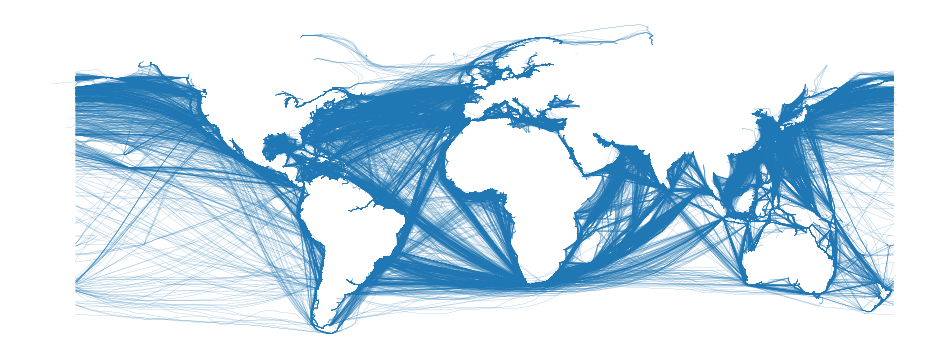

In [77]:
fig, ax = plt.subplots(figsize=(12, 14))
distances2.plot(ax=ax, linewidth=0.1)
plt.axis("off")

In [78]:
ports.head()

,index,PORT_NAME,INDEX_NO,coords,geometry
0,49159,Terminal Pesquero Cta. Quiane,NaN,"((-70.31722387298942, -18.513597026467323),)",POINT (-70.31722 -18.51360)
1,49164,Oil Berth,NaN,"((-61.86886473007713, 17.150384410999997),)",POINT (-61.86886 17.15038)
2,16,Port of Basamuk,NaN,"((146.14295817405977, -5.53913255687803),)",POINT (146.14296 -5.53913)
3,26,Victoria,NaN,"((-123.32715191091728, 48.402783083729446),)",POINT (-123.32715 48.40278)
4,34,NaN,NaN,"((126.50786074843957, 36.333661512471735),)",POINT (126.50786 36.33366)


In [79]:
len(distances2.loc[distances2.land_intersect ==1])

924

In [80]:
# distances2.loc[distances2.land_intersect ==1].explore()

In [81]:
# import git
# import os
# git_repo = git.Repo(join(expanduser("~"), "Repos", "red-sea-monitoring", "notebooks"), search_parent_directories=True)
# git_root = git_repo.git.rev_parse("--show-toplevel")
# sys.path.append(join(git_root, "src"))
# from red_sea_monitoring.utils import *

In [82]:
# chokepoints = get_chokepoints()
# chokepoints.loc[:, "geometry"] = chokepoints.apply(
#     lambda x: Point(x.lon, x.lat), axis=1
# )
# chokepoints = gpd.GeoDataFrame(
#     chokepoints, geometry="geometry", crs="EPSG:4326"
# )
# # List areas of interest
# aois = ["Bab el-Mandeb Strait", "Cape of Good Hope", "Suez Canal", "Strait of Hormuz"]

In [83]:
# azimuthal = "ESRI:54032"
# chokepoints_sel = chokepoints.loc[chokepoints.portname.isin(aois)].copy()
# # chokepoints_sel
# chokepoints_sel = chokepoints_sel.to_crs(azimuthal)
# chokepoints_sel.loc[:, "geometry"] = chokepoints_sel.buffer(500000)
# chokepoints_sel = chokepoints_sel.to_crs(wgs)

In [84]:
# chokepoints_sel

In [85]:
# circle = chokepoints_sel.geometry.values[0]
# circle

In [86]:
# center_x, center_y = circle.centroid.x, circle.centroid.y
# radius = circle.bounds[2] - center_x  # Calculate radius
# import shapely.geometry as sg
# line = sg.LineString([(center_x, center_y - radius), (center_x, center_y + radius)])


## Split by Chokepoint

In [94]:
import json
chokepoints_str = '{"type":"FeatureCollection","features":[{"type":"Feature","properties":{"Port_name":"Bab el-Mandeb Strait","Country":"chokepoint"},"geometry":{"type":"Polygon","coordinates":[[[43.309777,12.493873],[43.331355,12.474386],[43.514229,12.664987],[43.479704,12.669198],[43.479704,12.669198],[43.309777,12.493873]]]}},{"type":"Feature","properties":{"Port_name":"Suez Canal","Country":"chokepoint"},"geometry":{"type":"Polygon","coordinates":[[[32.553653,29.932182],[32.560088,29.926227],[32.583646,29.944185],[32.585828,29.955619],[32.580702,29.956848],[32.570668,29.942484],[32.570668,29.942484],[32.553653,29.932182]]]}},{"type":"Feature","properties":{"Port_name":"Cape of Good Hope","Country":"chokepoint"},"geometry":{"type":"Polygon","coordinates":[[[19.877499,-34.845363],[19.910717,-37.614427],[19.9628,-37.616709],[19.944734,-36.60437],[19.926568,-34.850397],[19.926568,-34.850397],[19.877499,-34.845363]]]}}]}'
chokepoints_gdf = (
    gpd.GeoDataFrame.from_features(json.loads(chokepoints_str))
    .rename(columns={"geometry": "port_boundary"})
    .set_geometry("port_boundary")
    .set_crs("EPSG:4326")
)

In [95]:
# for idx, row in distances2.head(10000).iterrows():
#     if row.geometry.intersects(chokepoints_gdf.unary_union):
#         print(idx)
#         break

In [96]:
# row = distances2.iloc[0]
# row_gdf = distances2.loc[[335]].copy()
# row = distances2.loc[335]

In [97]:
# chokepoints_sel = chokepoints_gdf.copy()

In [98]:
# row.geometry.intersects(chokepoints_sel.unary_union)

In [99]:
# chokepoint_gdf = chokepoints_sel.loc[chokepoints_sel.intersects(row.geometry)].copy()
# chokepoint = chokepoint_gdf.iloc[0]
# chokepoint

In [100]:
# row.geometry.intersects(chokepoint.port_boundary.boundary)

In [101]:
# m = row_gdf.explore()
# chokepoint_gdf.explore(m=m, color="red")
# m

In [102]:
from shapely.ops import split, linemerge
from shapely.geometry import GeometryCollection

In [103]:
# t = split(row.geometry, chokepoint.port_boundary)
# for geom in t.geoms:
#     print(geom.length)

In [104]:
# p1 = row.copy()
# p2 = row.copy()

# p1.geometry = t.geoms[0]
# p2.geometry = linemerge(t.geoms[1:])

In [105]:
# p1.next_port = chokepoint.Port_name
# p2.prev_port = chokepoint.Port_name

In [106]:
# distances2.loc[335]

In [107]:
# res = []
# res.append(p1)
# res.append(p2)

In [108]:
pdc = "EPSG:3832"
wgs = "EPSG:4326"
azimuthal = "ESRI:54032"
rob = "ESRI:54030"
merc = "EPSG:3857"

In [109]:
# distances3 = gpd.GeoDataFrame(res, geometry="geometry", crs=wgs)
# distances3 = distances3.to_crs(azimuthal)
# distances3

In [110]:
# distances3.loc[:, "original_index"] = distances3.index
# distances3.loc[:, "original_distance"] = distances3['distance']
# distances3.loc[:, "distance"] = (distances3.geometry.length) / 1000
# distances3

In [111]:
def split_route(row, chokepoints_gdf):
    chokepoint_gdf = chokepoints_gdf.loc[chokepoints_gdf.intersects(row.geometry)].copy()
    if len(chokepoint_gdf) > 0:
        # return []
        chokepoint = chokepoint_gdf.iloc[0]
        t = split(row.geometry, chokepoint.port_boundary)
        # res = []
        if len(t.geoms) > 0:
            p1 = row.copy()
            p2 = row.copy()
            p1.geometry = t.geoms[0]
            p2.geometry = linemerge(t.geoms[1:])
            
            p1.next_port = chokepoint.Port_name
            p2.prev_port = chokepoint.Port_name
            return[p1, p2]
    else:
        print(f"No chokepoint found for {row.name}")
        return None
        # for i, geom in enumerate(t.geoms):
        #     p = row.copy()
        #     p.geometry = geom
        #     if i == 0:
        #         p.next_port = chokepoint.Port_name
        #     elif i == len(t.geoms) - 1:
        #         p.prev_port = chokepoint.Port_name
        #     res.append(p)

In [112]:
distances_sub = distances2.loc[distances2.intersects(chokepoints_gdf.unary_union)].copy()
len(distances_sub)

2535

In [113]:
res = []
res

[]

In [114]:
for idx, row in distances_sub.iterrows():
    split_rows = split_route(row, chokepoints_gdf)
    if split_rows is not None:
        res.extend(split_rows)

In [115]:
distances3 = gpd.GeoDataFrame(res, geometry="geometry", crs=wgs)
distances3 = distances3.to_crs(azimuthal)
distances3

,trip_count,prev_port,next_port,distance,frequency,geometry,n_components,land_intersect,index,n_vertices
6114,1866491,3764,Suez Canal,283.994690,0.3,"LINESTRING (3226455.212 3631660.552, 3224208.8...",1.0,0.717158,6114,21
6114,1866491,Suez Canal,2214,283.994690,0.3,"LINESTRING (3277092.361 3485272.128, 3277185.4...",1.0,0.717158,6114,21
4987,1648653,3764,Suez Canal,240.896790,0.7,"LINESTRING (3226455.212 3631660.552, 3223816.9...",1.0,0.757848,4987,22
4987,1648653,Suez Canal,2214,240.896790,0.7,"LINESTRING (3276690.927 3484892.026, 3276551.7...",1.0,0.757848,4987,22
41743,2373626,6972,Bab el-Mandeb Strait,6528.593681,0.4,"LINESTRING (3272322.205 3480671.978, 3276084.3...",1.0,0.000000,41743,410
...,...,...,...,...,...,...,...,...,...,...
13937919,2477738,Cape of Good Hope,4021,16329.725925,1.0,"LINESTRING (1933235.497 -3941165.368, 1928543....",1.0,0.002266,13937919,1028
13952165,2493847,45066,Cape of Good Hope,19647.237921,1.0,"LINESTRING (375611.511 712099.611, 375650.997 ...",1.0,0.000487,13952165,1068
13952165,2493847,Cape of Good Hope,1975,19647.237921,1.0,"LINESTRING (1928628.377 -3940019.423, 1933240....",1.0,0.000487,13952165,1068
13994160,2924037,4092,Cape of Good Hope,22292.771583,1.0,"LINESTRING (-5101943.571 -4037735.483, -510001...",1.0,0.000000,13994160,1311


In [116]:
distances3.loc[:, "original_index"] = distances3.index
distances3.loc[:, "original_distance"] = distances3['distance']
distances3.loc[:, "distance"] = (distances3.geometry.length) / 1000
distances3

,trip_count,prev_port,next_port,distance,frequency,geometry,n_components,land_intersect,index,n_vertices,original_index,original_distance
6114,1866491,3764,Suez Canal,175.431891,0.3,"LINESTRING (3226455.212 3631660.552, 3224208.8...",1.0,0.717158,6114,21,6114,283.994690
6114,1866491,Suez Canal,2214,46.880371,0.3,"LINESTRING (3277092.361 3485272.128, 3277185.4...",1.0,0.717158,6114,21,6114,283.994690
4987,1648653,3764,Suez Canal,164.184105,0.7,"LINESTRING (3226455.212 3631660.552, 3223816.9...",1.0,0.757848,4987,22,4987,240.896790
4987,1648653,Suez Canal,2214,46.430345,0.7,"LINESTRING (3276690.927 3484892.026, 3276551.7...",1.0,0.757848,4987,22,4987,240.896790
41743,2373626,6972,Bab el-Mandeb Strait,1905.385948,0.4,"LINESTRING (3272322.205 3480671.978, 3276084.3...",1.0,0.000000,41743,410,41743,6528.593681
...,...,...,...,...,...,...,...,...,...,...,...,...
13937919,2477738,Cape of Good Hope,4021,5020.539683,1.0,"LINESTRING (1933235.497 -3941165.368, 1928543....",1.0,0.002266,13937919,1028,13937919,16329.725925
13952165,2493847,45066,Cape of Good Hope,4970.972343,1.0,"LINESTRING (375611.511 712099.611, 375650.997 ...",1.0,0.000487,13952165,1068,13952165,19647.237921
13952165,2493847,Cape of Good Hope,1975,11746.905683,1.0,"LINESTRING (1928628.377 -3940019.423, 1933240....",1.0,0.000487,13952165,1068,13952165,19647.237921
13994160,2924037,4092,Cape of Good Hope,7145.666398,1.0,"LINESTRING (-5101943.571 -4037735.483, -510001...",1.0,0.000000,13994160,1311,13994160,22292.771583


In [117]:
distances4 = distances2.copy()

In [118]:
distances3.original_index.unique()

array([    6114,     4987,    41743, ..., 13937919, 13952165, 13994160])

In [119]:
distances4 = distances4.drop(distances3.original_index.unique()).copy()

In [120]:
distances3 = distances3.drop(columns=["original_index", "original_distance"])
distances3 = distances3.to_crs(wgs)

In [121]:
distances_final = pd.concat([distances4, distances3], sort=False).reset_index(drop=True)

In [122]:
distances_final.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [123]:
chokepoints_gdf.loc[:, "geometry"] = chokepoints_gdf.geometry.representative_point()

In [124]:
chokepoints_gdf.rename(columns={"Port_name": "PORT_NAME"}, inplace=True)

In [125]:
chokepoints_gdf.loc[:, "index"] = chokepoints_gdf['PORT_NAME']

In [126]:
chokepoints_gdf[["index", "PORT_NAME", "geometry"]]

,index,PORT_NAME,geometry
0,Bab el-Mandeb Strait,Bab el-Mandeb Strait,POINT (43.41242 12.57943)
1,Suez Canal,Suez Canal,POINT (32.56841 29.93733)
2,Cape of Good Hope,Cape of Good Hope,POINT (19.91187 -35.72738)


In [127]:
ports2 = pd.concat([ports, chokepoints_gdf[["index", "PORT_NAME", "geometry"]]], sort=False).reset_index(drop=True)

In [128]:
ports2.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Convert to Graph Network

In [130]:
# G = gn.edges_and_nodes_gdf_to_graph(
#     nodes_df=ports,
#     edges_df=distances2,
#     node_tag="index",
#     u_tag="prev_port",
#     v_tag="next_port",
#     geometry_tag="geometry",
#     largest_G=False,
#     discard_node_col=[],
#     checks=False,
#     add_missing_reflected_edges=False,
#     oneway_tag=None,
# )

In [131]:
G = gn.edges_and_nodes_gdf_to_graph(
    nodes_df=ports2,
    edges_df=distances_final,
    node_tag="index",
    u_tag="prev_port",
    v_tag="next_port",
    geometry_tag="geometry",
    largest_G=False,
    discard_node_col=[],
    checks=False,
    add_missing_reflected_edges=False,
    oneway_tag=None,
)

Save graph

In [93]:
# gn.save(G, "G_sea_routes_fix", routes_dir, pickle=False, nodes=True, edges=True)
# with open(join(routes_dir, "G_sea_routes_fix.gpickle"), "wb") as f:
#     pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

In [132]:
gn.save(G, "G_sea_routes_v2", routes_dir, pickle=False, nodes=True, edges=True)
with open(join(routes_dir, "G_sea_routes_v2.gpickle"), "wb") as f:
    pickle.dump(G, f, pickle.HIGHEST_PROTOCOL)

In [101]:
G.graph["crs"] = wgs  # wgs

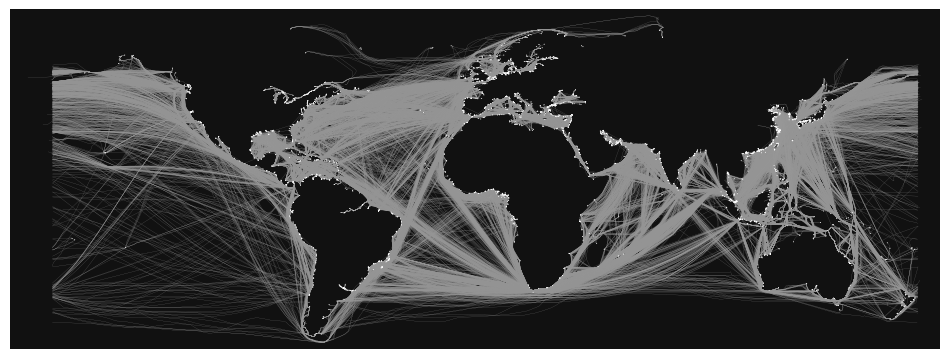

In [102]:
fig, ax = ox.plot_graph(G, figsize=(12, 14), node_size=0.5, edge_linewidth=0.1)

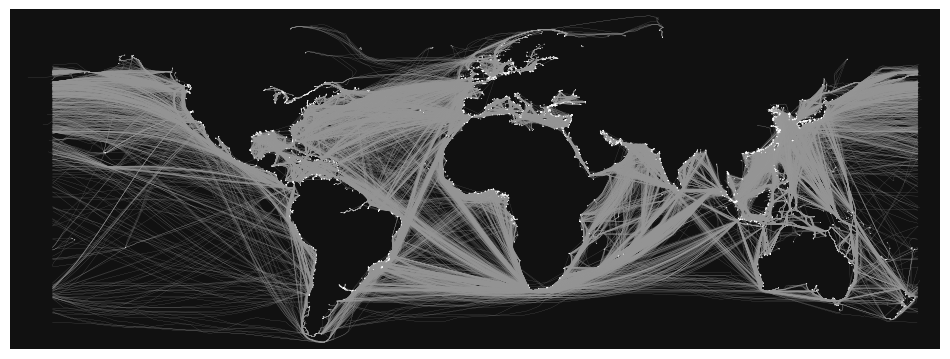

In [289]:
fig, ax = ox.plot_graph(G, figsize=(12, 14), node_size=0.5, edge_linewidth=0.1)